# Interbank Network Simulation (Refined)

We use Furfine algorithm to calculate the contagion effects of systemic risk in a randomly generated financial network. This is done by few steps:

1. Randomly defaulting a bank in the network.
2. Recalculate the total assets of each bank connected to the bank by subtracting it with liabilities.
3. If total assets < 0, default the bank, and repeat step 2 and 3 with reference from this bank.

## Generate a Random Financial Network

In [1]:
EXTERNAL_ASSETS = 0.8

In [22]:
class Bank(object):
    def __init__(self, bank_id, interbank_assets=0.2, liabilities=0.96, default=False):
        self.bank_id = bank_id
        self.interbank_assets = interbank_assets
        self.liabilities = liabilities
        self.default = default
        self.bank_connected = []
        global EXTERNAL_ASSETS
        self.total_assets = self.interbank_assets + EXTERNAL_ASSETS
        self.edges = [] #element of edges: (the bank itself, the bank it borrows money from, the amount of liabilities)
        
    #For NetworkX to label the bank based on ID.
    def __str__(self):
        return str(self.bank_id)
    
    #This function is called when the bank connected to this bank defaults, transmitting its loss to the asset.
    def update_total_assets(self, loss):
        self.total_assets = self.total_assets - loss
        if(self.total_assets < 0):
            self.default_bank()
        
    #This function is called every time the bank borrows money from a new bank.  
    def update_connection(self, bank):
        self.bank_connected.append(bank)
    
    #This function is called when the bank is set to default.
    def default_bank(self):
        self.default = True
        for bank in self.bank_connected:
            bank.update_total_assets(self.current_liabilities())
    
    #Erdos Renyi, where the link weights should be liabilities/k
    def current_liabilities(self):
        k = len(self.bank_connected)
        return self.liabilities/k
    
    #This function is called when the bank finish borrowing from other bank, and it can list out all edges (from itself to other banks) with weight.
    def compile_connection(self):
        print(self.bank_connected)
        for bank in self.bank_connected:
            self.edges.append((self.bank_id, bank.bank_id, self.current_liabilities()))

## Generate the Graph

In [25]:
class Graph(object):
    def __init__(self, bank_number=5, borrow_probability=0.15):
        self.bank_number = bank_number
        self.borrow_probability = borrow_probability
        self.bank_list = []
    
    #Generate random banks and random connections between banks.
    def generate_bank(self):
        for i in range(self.bank_number):
            newBank = Bank(bank_id=i)
            self.bank_list.append(newBank)
        
        potential_lender = self.bank_list.copy()
        
        for bank in self.bank_list:
            for lender in potential_lender:
                import random
                tendency = random.uniform(0, 1) #generate tendency of bank borrowing from lender. the lower, the more tendency.
                if(bank!=lender and tendency < self.borrow_probability):
                    print(bank,lender)
                    bank.update_connection(lender)
            bank.compile_connection()

    def draw_graph(self):
        self.generate_bank()
        import pygraphviz as pgv
        G=pgv.AGraph(strict=False,directed=True)
        G.edge_attr['penwidth']=1.0
        G.edge_attr['fontcolor']='red'
        G.edge_attr['len']=1.5
        for bank in self.bank_list:
            for edge in bank.edges:
                G.add_edge(edge[0], edge[1], label=round(edge[2],2))        
        print(G)
        
        G.layout()
        G.draw('network.png') 

0 4
0 9
[<__main__.Bank object at 0x7f19441dbf98>, <__main__.Bank object at 0x7f19441db6a0>]
[]
2 1
3 9
4 6
4 9
[<__main__.Bank object at 0x7f19441db9e8>, <__main__.Bank object at 0x7f19441db6a0>]
[]
6 1
6 4
[<__main__.Bank object at 0x7f194415eeb8>, <__main__.Bank object at 0x7f19441dbf98>]
7 0
8 0
8 4
8 7
[<__main__.Bank object at 0x7f194415ee80>, <__main__.Bank object at 0x7f19441dbf98>, <__main__.Bank object at 0x7f19441dbb38>]
9 5
digraph "" {
	edge [fontcolor=red,
		len=1.5,
		penwidth=1.0
	];
	0 -> 4	 [label=0.48];
	0 -> 9	 [label=0.48];
	4 -> 9	 [label=0.48];
	4 -> 6	 [label=0.48];
	9 -> 5	 [label=0.96];
	6 -> 4	 [label=0.48];
	6 -> 1	 [label=0.48];
	2 -> 1	 [label=0.96];
	3 -> 9	 [label=0.96];
	7 -> 0	 [label=0.96];
	8 -> 0	 [label=0.32];
	8 -> 4	 [label=0.32];
	8 -> 7	 [label=0.32];
}



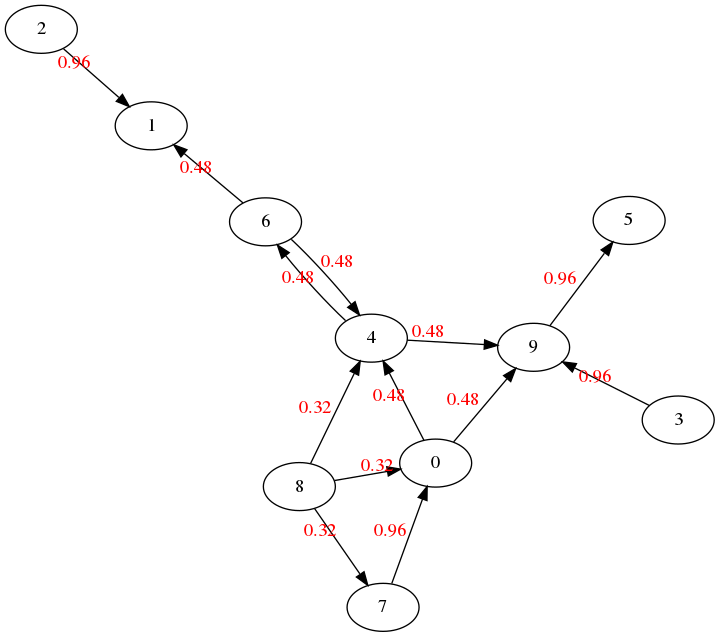

In [27]:
graph = Graph(bank_number=10)
graph.draw_graph()
from IPython.display import Image
Image('network.png')